In [1]:
# import necessary libraries for data manipulation, model evaluation, and plotting
!pip install transformers[torch] accelerate -U plotting

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_fscore_support
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from tensorboard.backend.event_processing import event_accumulator
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from transformers import TrainerCallback

import os
import pandas as pd
import datetime
import sys
from sklearn.utils import resample

import torch
from torch.optim import AdamW  # variant of Adam with weight decay
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2ForSequenceClassification, GPT2Tokenizer, TrainingArguments, Trainer, AutoTokenizer, AutoModelForSequenceClassification
from transformers import EarlyStoppingCallback

import json
import numpy as np
from transformers import EarlyStoppingCallback

from sklearn.utils.class_weight import compute_class_weight

import datetime
import sklearn
from transformers import get_linear_schedule_with_warmup
from transformers import EarlyStoppingCallback


In [2]:
# Cell 1
# data preprocessing

# need to have separate models for each sdoh
dataset = pd.read_csv("/content/PREPROCESSED-NOTES.csv")

# extract text data and specific SDoH categories from the dataset
text_data = dataset["text"].to_list()
sdoh_data = {
    "sdoh_community_present": dataset["sdoh_community_present"].to_list(),
    "sdoh_community_absent": dataset["sdoh_community_absent"].to_list(),
    "sdoh_education": dataset["sdoh_education"].to_list(),
    "sdoh_economics": dataset["sdoh_economics"].to_list(),
    "sdoh_environment": dataset["sdoh_environment"].to_list(),
    "behavior_alcohol": dataset["behavior_alcohol"].to_list(),
    "behavior_tobacco": dataset["behavior_tobacco"].to_list(),
    "behavior_drug": dataset["behavior_drug"].to_list()
}


# prepare directories for storing train-test split data for each SDoH category
base_path = 'test_train_split/behavior_drug'
os.makedirs(base_path, exist_ok=True)

# Iterate through each SDOH data category to split and save as separate CSV files
for category, data in sdoh_data.items():
    base_path = f"test_train_split/{category}"
    os.makedirs(base_path, exist_ok=True)

    # Split data for the current category into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(
        text_data, data, random_state=0, train_size=0.8, stratify=data
    ) #maybe try a different test size (0.7/0.3)

    # Save all splits as CSV files
    pd.DataFrame({"text": X_train}).to_csv(f"{base_path}/X_train.csv", index=False)
    pd.DataFrame({"text": X_val}).to_csv(f"{base_path}/X_val.csv", index=False)
    pd.DataFrame({category: y_train}).to_csv(f"{base_path}/y_train.csv", index=False)
    pd.DataFrame({category: y_val}).to_csv(f"{base_path}/y_val.csv", index=False)

In [3]:
# Functions

def save_metrics_to_csv(json_filepath, csv_filename):
    with open(json_filepath) as file:
        data = json.load(file)

        log_history = data['log_history']
        df = pd.DataFrame(log_history)

        df.to_csv(csv_filename, index=False)

def plot_metric_from_tensor(log_dir, output_dir, steps_per_epoch):

    # Calculate steps_per_epoch based on training data and training arguments
    # steps_per_epoch = len(train_dataset) // training_args.per_device_train_batch_size
    event_acc = event_accumulator.EventAccumulator(log_dir)
    event_acc.Reload()

    graph1_data = event_acc.Scalars("eval/loss")
    graph2_data = event_acc.Scalars("train/loss")

    # convert steps to epochs
    epochs1 = [event.step / steps_per_epoch for event in graph1_data]
    values1 = [event.value for event in graph1_data]

    epochs2 = [event.step / steps_per_epoch for event in graph2_data]
    values2 = [event.value for event in graph2_data]

    plt.figure(figsize=(10, 6))

    plt.plot(epochs1, values1, label="Validation Loss")
    plt.plot(epochs2, values2, label="Train Loss")

    plt.legend()

    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Overlap")
    # plt.show()

    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Save the graph to the specified folder
    plt.savefig(os.path.join(output_dir, 'metrics_plot.png'))
    plt.show()

# evaluation metrics function
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    f1 = f1_score(labels, preds, average='weighted')
    accuracy = accuracy_score(labels, preds)
    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

def get_latest_checkpoint(folder_path):
    # Get a list of all files and directories in the specified folder
    files_and_dirs = os.listdir(folder_path)

    # Filter only directories (assumed to be checkpoints)
    checkpoint_dirs = [d for d in files_and_dirs if os.path.isdir(os.path.join(folder_path, d))]

    if not checkpoint_dirs:
        print("No checkpoint directories found.")
        return None

    # Extract the checkpoint numbers from the directory names
    checkpoint_numbers = [int(d.split('-')[1]) for d in checkpoint_dirs]

    # Identify the directory with the highest checkpoint number
    latest_checkpoint = os.path.join(folder_path, f"checkpoint-{max(checkpoint_numbers)}")

    return latest_checkpoint

checkpoint_path = '/content/checkpoints/checkpoint_epoch_{epoch}.pth'
best_model_path = '/content/checkpoints/best_model.pth'


# Saving the checkpoints
def save_checkpoint(model, optimizer, epoch, loss, val_loss, is_best=False):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
        'val_loss': val_loss
    }
    torch.save(checkpoint, checkpoint_path)
    if is_best:
        torch.save(model.state_dict(), best_model_path)

###### TEST 1 ######
###### TEST 4 ######
###### TEST 5 ######


In [4]:
# Define label_columns here
label_columns = [
    'sdoh_community_present', 'sdoh_community_absent', 'sdoh_education',
    'sdoh_economics', 'sdoh_environment', 'behavior_alcohol',
    'behavior_tobacco', 'behavior_drug'
]

sdoh_community_education = {
      0: 'False',
      1: 'True',
}

# economics and environment
sdoh_economics_environment = {
      0: 'None',
      1: 'True',
      2: 'False',
}

# alcohol, drug, tobacco
sdbh_alcohol_drug_tobacco = {
      0: 'None',
      1: 'Present',
      2: 'Past',
      3: 'Never',
      4: 'Unsure'
}


dataset['sdoh_community_present'] = dataset.sdoh_community_present.map(sdoh_community_education)
num_labels = len(sdoh_community_education)

#num_of_labels = len(np.unique(df[Sdoh_name]))

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token
configuration = GPT2ForSequenceClassification.config_class.from_pretrained("gpt2", num_labels= num_labels)
configuration.pad_token_id = tokenizer.pad_token_id
model = GPT2ForSequenceClassification(configuration)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


TEST MODEL
TEST MODEL 2


In [5]:
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=1e-5)

In [6]:
dataset = pd.read_csv("/content/PREPROCESSED-NOTES.csv")
text_data = dataset["text"].to_list()
sdoh_data = dataset["sdoh_community_present"].to_list()

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(text_data, sdoh_data, random_state=0, train_size=0.8,
                                                  stratify=sdoh_data)
max_seq_length = 100

# Calculate the number of trainable parameters in the model
num_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
model_size_MB = num_trainable_params * 4 / (1024 ** 2)
effective_batch = 8 / (50*4*model_size_MB) #gpu/seqlength * 4 * model size

In [7]:
# define training arguments and start training with the Trainer
train_encodings = tokenizer(X_train, truncation=True, padding='max_length', max_length=max_seq_length, return_tensors='pt')
val_encodings = tokenizer(X_val, truncation=True, padding='max_length', max_length=max_seq_length, return_tensors='pt')

In [8]:
# IMPORTANT: change label to float for sdoh_economics, sdoh_environment

class CustomDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

In [9]:
train_dataset = CustomDataset(train_encodings, y_train)
val_dataset = CustomDataset(val_encodings,y_val)

In [10]:
timestamp_fortrain = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

tensor_logs = f'./logs/tensor_logs/{timestamp_fortrain}' #create seperate logs for tensor/epoch
os.makedirs(tensor_logs, exist_ok=True)
epoch_logs = f'./logs/epoch_logs/{timestamp_fortrain}'
os.makedirs(epoch_logs, exist_ok=True)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.520500,0.393135,0.812811,0.803090,0.819210,0.812811
2,0.364500,0.314132,0.861922,0.858111,0.864339,0.861922
3,0.269000,0.269599,0.896797,0.895050,0.897883,0.896797
4,0.199500,0.263435,0.912456,0.912129,0.912091,0.912456


###### TEST STAR ######
###### TEST TREE ######
###### TEST WHALE ######
###### TEST DOG ######
###### TEST 2 ######
###### TEST STAR ######
###### TEST TREE ######
###### TEST WHALE ######
###### TEST DOG ######
###### TEST 2 ######
###### TEST STAR ######
###### TEST TREE ######
###### TEST WHALE ######
###### TEST DOG ######
###### TEST 2 ######
###### TEST STAR ######
###### TEST TREE ######
###### TEST WHALE ######
###### TEST DOG ######
###### TEST 2 ######


###### TEST STAR ######
###### TEST TREE ######
###### TEST WHALE ######
###### TEST DOG ######
###### TEST 2 ######
###### TEST APPLE ######
###### TEST PEAR ######
###### TEST 3 ######


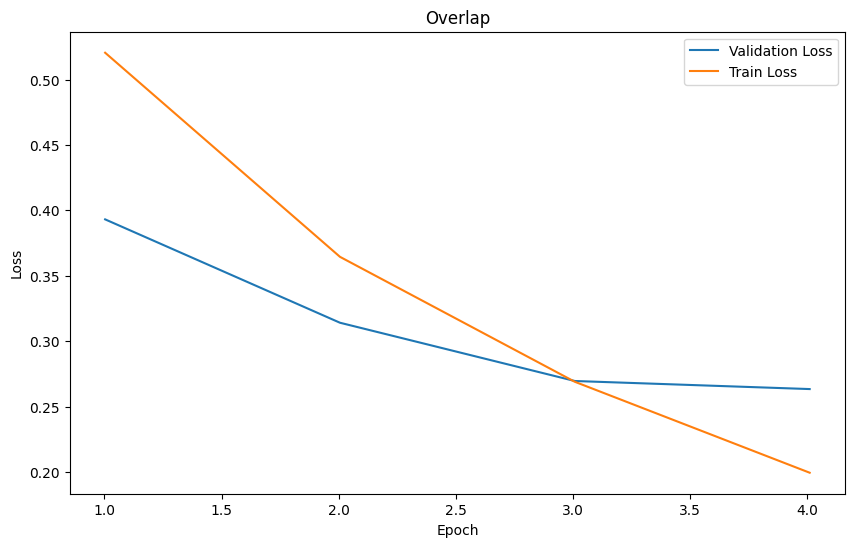

Evaluation Results: {'eval_loss': 0.2634352147579193, 'eval_accuracy': 0.9124555160142349, 'eval_f1': 0.91212927723497, 'eval_precision': 0.9120907404181426, 'eval_recall': 0.9124555160142349, 'eval_runtime': 8.6366, 'eval_samples_per_second': 162.679, 'eval_steps_per_second': 2.547, 'epoch': 4.0}


In [12]:
early_stopping = EarlyStoppingCallback(early_stopping_patience=3)

# training args - need to adjust
training_args = TrainingArguments(
      output_dir= epoch_logs,  # change to epoch log directory, convert to a text
      logging_strategy='epoch',  # characterize as epoch
      num_train_epochs=4, # have high epoch
      per_device_train_batch_size=16, #reduced batch size
      per_device_eval_batch_size=64,  # gradient accum if batch size of two, 64 approp
      save_strategy= 'epoch',
      warmup_steps=500,
      weight_decay=1e-5,
      logging_dir= tensor_logs,  # change to tensor logs
      evaluation_strategy="epoch",
      load_best_model_at_end=True,
      metric_for_best_model="eval_loss",
      greater_is_better=False,
      learning_rate=5e-6,
      lr_scheduler_type='linear',

)

trainer = Trainer(
      model=model,
      args=training_args,
      train_dataset=train_dataset,
      eval_dataset=val_dataset,
      compute_metrics=compute_metrics,
      #callbacks=[EarlyStoppingCallback(early_stopping_patience=3)], # 3 is a balance between giving the model enough chance  to improve and stopping early enough to prevent overfitting and unnecessary computation
)

# train the model
trainer.train()

# evaluate the model
evaluation_results = trainer.evaluate()

#readable results
steps_per_epoch = len(train_dataset) // training_args.per_device_train_batch_size
latest_checkpoint = get_latest_checkpoint(epoch_logs) # latest checkpoint update to csv
json_path = os.path.join(latest_checkpoint, 'trainer_state.json')
save_metrics_to_csv(json_path, 'eval_metric.csv') #update metrics
plot_metric_from_tensor(tensor_logs, 'graphs', steps_per_epoch)

save_directory = "/content/saved_models/gpt2"


os.makedirs(save_directory, exist_ok=True)
model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

print("Evaluation Results:", evaluation_results)

In [35]:
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class TestDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

# function to evaluate the trained model on test data
def evaluate_on_test_data(model_path, test_data_path, tokenizer_path, label_columns, sdoh_label_counts, max_seq_length=512, batch_size = 16):
    # Load the tokenizer and model
    best_checkpoint_path = os.path.join("/content/logs/epoch_logs/20240315_180803/checkpoint-704")
    tokenizer = GPT2Tokenizer.from_pretrained(tokenizer_path)
    model = GPT2ForSequenceClassification.from_pretrained(best_checkpoint_path)
    model.to(device)

    # Load the test data
    test_data = pd.read_csv(test_data_path)
    texts = test_data["TEXT"].tolist()

    test_encodings = tokenizer(texts, truncation=True, padding='max_length', max_length=max_seq_length, return_tensors='pt')
    test_dataset = TestDataset(test_encodings)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    model.eval()
    predictions = {label: [] for label in label_columns}

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating"):
            inputs = {key: val.to(device) for key, val in batch.items()}
            outputs = model(**inputs)
            logits = outputs.logits
            probs = torch.sigmoid(logits) if max(sdoh_label_counts.values()) > 2 else torch.softmax(logits, dim=-1)
            pred_labels = torch.argmax(probs, dim=1).cpu().numpy()
            for i, label in enumerate(label_columns):
                # Handle binary classification separately if needed
                predictions[label].extend(pred_labels if sdoh_label_counts[label] > 2 else probs[:, 1].cpu().numpy())

    results = []
    for label in label_columns:
        true_labels = np.array(test_data[label])
        pred_labels = np.array(predictions[label])
        accuracy = accuracy_score(true_labels, pred_labels > 0.5 if sdoh_label_counts[label] == 2 else pred_labels)
        precision = precision_score(true_labels, pred_labels > 0.5 if sdoh_label_counts[label] == 2 else pred_labels, average='weighted')
        recall = recall_score(true_labels, pred_labels > 0.5 if sdoh_label_counts[label] == 2 else pred_labels, average='weighted')
        f1 = f1_score(true_labels, pred_labels > 0.5 if sdoh_label_counts[label] == 2 else pred_labels, average='weighted')

        results.append({
            'Label': label,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1
        })

        print(f"Metrics for {label}:")
        print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
        # For multi-class, adjust zero_division and average as necessary
        print("Classification Report:")
        print(classification_report(true_labels, pred_labels > 0.5 if sdoh_label_counts[label] == 2 else pred_labels, zero_division=0))

    results_df = pd.DataFrame(results)
    results_df.to_csv('/content/model_evaluation_results.csv', index=False)
    print("Evaluation results saved to /content/model_evaluation_results.csv")

# Specify paths and label information
model_path = "saved_models/gpt2"
tokenizer_path = "saved_models/gpt2"
test_data_path = "/content/ANNOTATEDNOTES.csv"
sdoh_label_counts = {
    'sdoh_community_present': 2,
    'sdoh_community_absent': 2,
    'sdoh_education': 2,
    'sdoh_economics': 3,
    'sdoh_environment': 3,
    'behavior_alcohol': 5,
    'behavior_tobacco': 5,
    'behavior_drug': 5
}

# Evaluate the model on test data
evaluate_on_test_data(
    model_path="saved_models/gpt2",
    test_data_path="/content/ANNOTATEDNOTES.csv",
    tokenizer_path="saved_models/gpt2",
    label_columns=list(sdoh_label_counts.keys()),
    sdoh_label_counts=sdoh_label_counts,
    max_seq_length=512,
    batch_size=16
)

Evaluating:   0%|          | 0/332 [00:00<?, ?it/s]<ipython-input-35-8ccc85725850>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Evaluating: 100%|██████████| 332/332 [03:04<00:00,  1.80it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg

Metrics for sdoh_community_present:
Accuracy: 0.3863, Precision: 0.5590, Recall: 0.3863, F1 Score: 0.2628
Classification Report:
              precision    recall  f1-score   support

           0       0.37      0.95      0.53      1950
           1       0.67      0.06      0.11      3349

    accuracy                           0.39      5299
   macro avg       0.52      0.50      0.32      5299
weighted avg       0.56      0.39      0.26      5299

Metrics for sdoh_community_absent:
Accuracy: 0.8502, Precision: 0.8079, Recall: 0.8502, F1 Score: 0.8270
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      4718
           1       0.13      0.06      0.09       581

    accuracy                           0.85      5299
   macro avg       0.51      0.51      0.50      5299
weighted avg       0.81      0.85      0.83      5299

Metrics for sdoh_education:
Accuracy: 0.9239, Precision: 0.9526, Recall: 0.9239, F1 Score